# 🐶 End to End - Multiclass Dog Breed Classifications

This notebook builds an End-to-End Multiclass Dog Breed Classifier using Tensorflow 2.0 and Tensorflow Hub.

## 1.Problem
Identifying the breed of a dog given an image of a dog.


## 2.Data
[Dog Breed Identification - Kaggle Version](https://www.kaggle.com/c/dog-breed-identification/data)

## 3.Evaluation

- evaluated on `Multi Class Log Loss` between the predicted probability and the observed target.
- The evaluation is the file with prediction probabilities for each dog breed of each test image.

## 4.Features
Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dog (120 different classes).
* There are about 10,000+ images in both Training and Test Set.



# Setting up Data



In [ ]:
# unzip the file
# !unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

-----------

# Get our Workspace Ready

In [ ]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

# check for GPU availbility
print("GPU", 'available' if tf.config.list_physical_devices('GPU') else 'Not available.')

TF version:  2.4.0
Hub version:  0.11.0
GPU available


--------

# Getting our Data Ready (turning into Tensors)

- With all machine learning model, our data needs to be in numerical format. Turning our images into Tensors (numerical representations).

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

## let's access our data and check out the labels.

In [ ]:
labels_csv = pd.read_csv('drive/My Drive/Dog Vision/labels.csv')

print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     bdf6bdb0c025a71d9860ec28c4521b92  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## How many images are for each breed?

In [ ]:
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

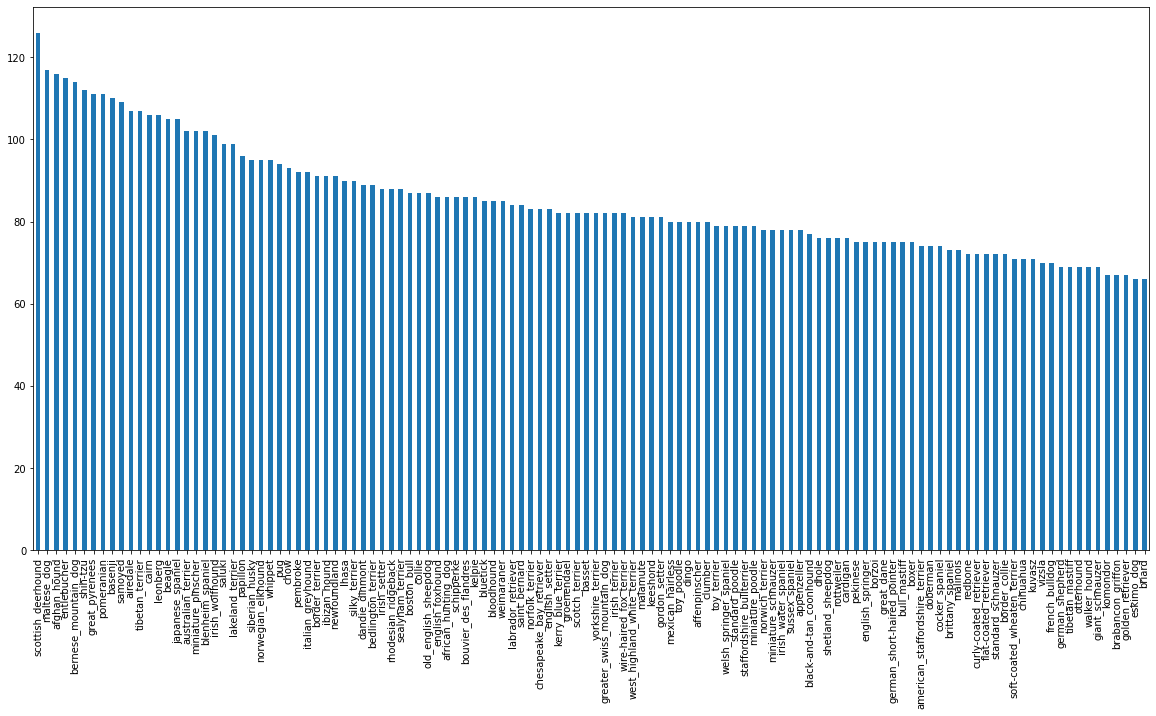

In [ ]:
# visualize the data
plt.figure(figsize=(20,10))
labels_csv['breed'].value_counts().plot(kind='bar');

In [ ]:
# what is the median of number of dogs per breed
labels_csv['breed'].value_counts().median()

82.0

There are abou 82 dogs per dog breed.

As per google recommendation, mininum images per class should be at least 10.

https://cloud.google.com/vision/automl/object-detection/docs/prepare

* `For each label you must have at least 10 images, each with at least one annotation`

* `However, for model training purposes it's recommended you use about 1000 annotations per label. In general, the more images per label you have the better your model will perform.`


In [ ]:
# let's explor an image
from IPython.display import Image

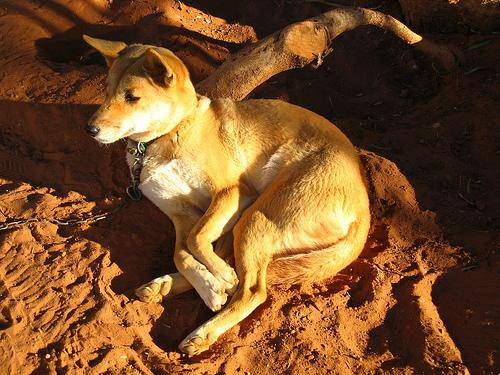

In [13]:
Image(data='/content/drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg')

-----------

## Getting Images and their labels

let's get the list of all of our images file pathnames.

In [14]:
labels_csv.head(2)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo


In [18]:
# create pathnames from image IDs
folder_path = '/content/drive/MyDrive/Dog Vision/train/'
file_extension = '.jpg'

filenames = [folder_path+fname+file_extension for fname in labels_csv['id']]

# check first 5 rows
filenames[:5]

['/content/drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [20]:
 # check whether number of file name matched actual image file names
import os
if  len(os.listdir('/content/drive/MyDrive/Dog Vision/train/')) == len(filenames):
  print('filenames folder has the same number of images as in train folder. You can proceed !!!')
else:
  print('filenames folder doe not have the same number of images as in train folder.')


filenames folder has the same number of images as in train folder. You can proceed !!!


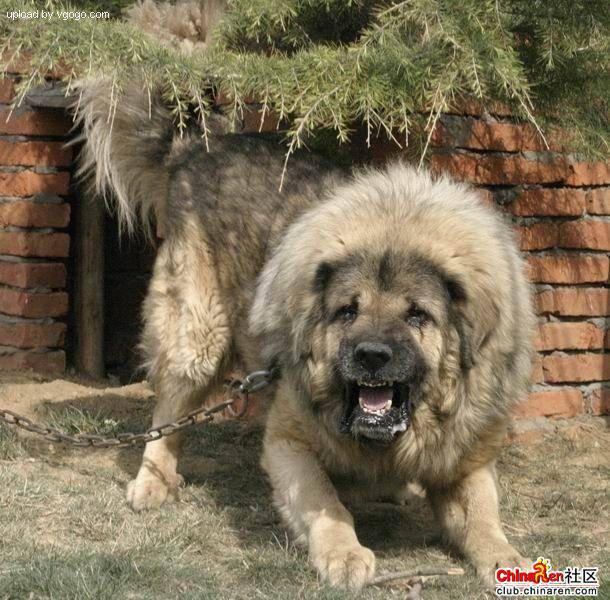

In [22]:
# random check
Image(filenames[9000])

In [25]:
labels_csv['breed'][9000]

'tibetan_mastiff'

-----------